# Семинар 8
## Градиентный бустинг и важность признаков

Сегодня на семинаре мы:
* Познакомимся с двумя фреймворками бустинга
* Займемся настройской их параметров
* Отберем признаки по важности для модели
* Решим задачу и сделаем анализ работы алгоритма

Мы будем решать задачу классификации на датасете [Parkinsons](https://archive.ics.uci.edu/ml/datasets/parkinsons). Он состоит из ряда биомедицинских измерений голоса 31 человека, 23 из которых страдают болезнью Паркинсона. Каждый столбец в таблице представляет собой конкретный показатель голоса, а каждая строка соответствует одной из 195 записей голоса пациентов. Необходимо отличить здоровых людей от людей с БП в соответствии со столбцом «статус», в котором установлено значение 0 для здоровых и 1 для больных паркинсоном.

**Мотивация:** поскольку болезнь Паркинсона является медленно прогрессирующей, очень сложно сразу заметить изменения в поведении человека, что может превести к запусканию развития болезни. Хотелось бы как-то постоянно мониторить состояние человека без необходимости частого посещения специалиста. Для этого можно разработать модель, которая будет отслеживать состояние человека и при только при подозрениях на начала развития болезни отправлять человека к врачу. Еще один способ применения -- обязательное обследование и анализ при помощи модели, чтобы отсеять здоровых пациентов для уменьшения нагрузки на врача.

Датасет имеет 23 биологических измерения голоса:

* 1 -- name - id пациент-запись;
* 2 -- MDVP:Fo(Hz) - Средняя основная частота вокала;
* 3 -- MDVP:Fhi(Hz) - Максимальная основная частота вокала;
* 4 -- MDVP:Flo(Hz) - Минимальная основная частота вокала;
* 5-9 -- MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP - Несколько показателей изменения основной частоты;
* 10-16 -- MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA - Несколько показателей вариации амплитуды;
* 17-18 -- NHR, HNR - Две меры отношения шума к тональным компонентам в голосе;
* 20-21 -- RPDE, D2 - Две нелинейные меры динамической сложности;
* 22 -- DFA - экспонента масштабирования фрактала сигнала;
* 23-25 -- spread1, spread2, PPE - три нелинейные меры изменения основной частоты.

Столбце со статусом пациента:
* 19 -- status - Состояние здоровья субъекта (единица) - болезнь Паркинсона, (ноль) - здоров.

In [ ]:
# Импортируем наши стандартные библиотеки
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

### Подготовка данных

In [ ]:
# Скачаем данные при помощи команды gdown (второй аргумент -- это не ссылка на файл!)
# file_id = 13iZSrbgIzYemEQiRqLWUsOpDeTiEpsU9
! gdown https://drive.google.com/uc?id=13iZSrbgIzYemEQiRqLWUsOpDeTiEpsU9

Downloading...
From: https://drive.google.com/uc?id=13iZSrbgIzYemEQiRqLWUsOpDeTiEpsU9
To: /content/parkinsons.csv
100% 1.79M/1.79M [00:00<00:00, 104MB/s]


In [ ]:
# Мы будем использовать измененный датасет с записями пациентов, потенциально больных болезнью паркинсона
# Считаем данные, которые прилагаются к ноутбуку помощи метода read_csv библиотеки pandas

df = pd.read_csv("parkinsons.csv")

In [ ]:
# Посмотрим на наши данные

df.sample(10)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status,name
689,198.568779,167.658460,190.941291,0.003184,0.000020,0.001326,0.001389,0.003973,0.018522,0.170369,...,-0.002895,25.314047,0.417197,0.720096,-7.071857,0.218036,2.238002,0.082716,0.0,689
1197,176.936527,182.790548,169.703966,0.001111,0.000005,0.000143,0.001070,0.000412,0.015397,0.112228,...,-0.007464,26.622150,0.428757,0.743963,-6.298169,0.224161,2.264319,0.180245,1.0,1197
3404,133.715708,198.757792,65.483841,0.007600,0.000059,0.004111,0.004094,0.012331,0.044882,0.403507,...,0.035241,19.542335,0.558498,0.705936,-5.141896,0.212572,2.344037,0.244557,1.0,3404
1355,148.803511,267.580389,95.240364,0.009884,0.000075,0.005896,0.004726,0.017690,0.047335,0.466012,...,0.078458,18.238645,0.594891,0.644464,-4.935012,0.274852,2.540369,0.203794,1.0,1355
428,238.005324,279.019637,199.076911,0.004348,0.000015,0.002594,0.002450,0.007785,0.018450,0.185279,...,0.013221,22.565494,0.364081,0.662005,-6.887971,0.098694,2.295051,0.109274,0.0,428
3748,111.488440,353.678176,99.550459,0.010492,0.000088,0.005768,0.006198,0.017315,0.038779,0.355736,...,0.040146,19.751916,0.581518,0.804564,-4.473758,0.273044,2.182439,0.313651,1.0,3748
3937,163.353140,141.907504,145.823923,-0.000895,-0.000007,-0.000949,-0.000202,-0.002834,0.022644,0.185962,...,-0.028024,25.033949,0.462714,0.729625,-6.521909,0.209993,2.202954,0.134819,1.0,3937
3378,123.295224,136.961227,101.744060,0.003525,0.000039,0.001203,0.002819,0.003583,0.021697,0.158840,...,-0.027802,25.697297,0.463704,0.780560,-5.619277,0.267294,1.952446,0.229162,1.0,3378
791,148.863309,179.901456,130.661755,0.002351,0.000024,0.001104,0.001845,0.003306,0.015668,0.139697,...,0.000228,24.545527,0.562775,0.667860,-6.158455,0.161054,1.809275,0.167305,0.0,791
2634,141.231004,151.598561,62.163857,0.013985,0.000103,0.008187,0.006893,0.024514,0.045865,0.463954,...,0.083711,16.984672,0.590142,0.730931,-5.054430,0.277926,2.656403,0.254663,1.0,2634


In [ ]:
# Проверим есть ли в наших данных пропуски и заодно посомтрим на типы данных при помощи метода info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       4000 non-null   float64
 1   MDVP:Fhi(Hz)      4000 non-null   float64
 2   MDVP:Flo(Hz)      4000 non-null   float64
 3   MDVP:Jitter(%)    4000 non-null   float64
 4   MDVP:Jitter(Abs)  4000 non-null   float64
 5   MDVP:RAP          4000 non-null   float64
 6   MDVP:PPQ          4000 non-null   float64
 7   Jitter:DDP        4000 non-null   float64
 8   MDVP:Shimmer      4000 non-null   float64
 9   MDVP:Shimmer(dB)  4000 non-null   float64
 10  Shimmer:APQ3      4000 non-null   float64
 11  Shimmer:APQ5      4000 non-null   float64
 12  MDVP:APQ          4000 non-null   float64
 13  Shimmer:DDA       4000 non-null   float64
 14  NHR               4000 non-null   float64
 15  HNR               4000 non-null   float64
 16  RPDE              4000 non-null   float64


In [ ]:
# Видим, что у нас уже нет пропусков и все данные являются числовыми, что сильно упрощает работу
# Поэтому перед тем как переходить к обучению модели, посмотрим, еще, на статистики каждого признака 
# Воспользовавшись методом describe

df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status,name
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,154.066451,196.497430,116.430862,0.006147,0.000043,0.003261,0.003412,0.009784,0.029549,0.280437,...,0.024310,21.882981,0.499643,0.718363,-5.701410,0.226435,2.375166,0.205393,0.701250,1999.500000
std,31.684268,64.826518,33.434512,0.003534,0.000026,0.002154,0.002029,0.006462,0.014124,0.145843,...,0.028795,3.331937,0.076340,0.039846,0.883783,0.063590,0.284840,0.071868,0.457767,1154.844867
min,64.845446,3.810054,29.313386,-0.002290,-0.000013,-0.001959,-0.001997,-0.005887,-0.006255,-0.097950,...,-0.042461,10.734641,0.245591,0.596168,-8.098224,0.033613,1.427841,0.031184,0.000000,0.000000
25%,132.597006,153.271882,93.782711,0.003697,0.000025,0.001788,0.001970,0.005361,0.018477,0.169647,...,0.005831,19.725926,0.446157,0.690808,-6.361474,0.181697,2.177314,0.148182,0.000000,999.750000
50%,149.769369,189.146050,110.711593,0.005540,0.000040,0.002865,0.003031,0.008594,0.027119,0.254111,...,0.019541,22.005644,0.500779,0.717595,-5.652116,0.226965,2.361430,0.206103,1.000000,1999.500000
75%,171.528004,230.131756,132.531355,0.007947,0.000058,0.004341,0.004454,0.013005,0.038345,0.364116,...,0.037823,24.166649,0.554109,0.746250,-5.071574,0.270018,2.567220,0.255103,1.000000,2999.250000
max,311.480923,543.607861,271.022682,0.024855,0.000185,0.015691,0.014328,0.047060,0.091909,0.910901,...,0.209710,32.739197,0.741927,0.835685,-2.852659,0.425241,3.573618,0.464673,1.000000,3999.000000


In [ ]:
# Посмотрим на соотношение классов в данных

print(f"В датасете {len(df)} объектов")
print(f"В данных {sum(df.status == 0)} объектов класса 0")
print(f"В данных {sum(df.status == 1)} объектов класса 1")

В датасете 4000 объектов
В данных 1195 объектов класса 0
В данных 2805 объектов класса 1


Видим необычный датасет -- в нем доминирует таргетный класс.
Поэтому нам надо быть осторожными при подсчете метрик, поскольку распределение классов в жизни будет диаметрально противоположным!

Один из вариантов решения -- инвертировать классы, но в данном случае, мы будем просто аккуратны в подсчете метрик -- нам важно, чтобы нулевой класс был почти полностью распознан верно.

Для визуализации у нас многовато признаков. Давайте построим baseline модель, проведем простой отбор признаков и уже после этого попытаем проанализировать данные по графикам.

In [ ]:
# Для решения задачи будем использовать функцию classification_report модуля metrics библиотеки sklearn
# Она считает все популярные метрики классификации
# А для того, чтобы отслеживать ошибки на каждый класс, будем использовать confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Разделим данные на признаки и таргет не забыв удалить столбце с id

X = df.drop(columns=["status", "name"])
y = df["status"]

In [ ]:
# Разобьем данные на обучение и тест при помощи функции train_test_split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=13)

### Обучим baseline модель

Поскольку сегодня мы хотим попрактиковаться в использовании бустингов, мы будем использовать их в качестве baseline, но параметры возьмем по умолчанию.

In [ ]:
# Установим catboost

!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.2 MB/s eta 0:00:00


In [ ]:
# Импортируем CatBoost и LightGBM
import catboost as cb
import lightgbm as lgb

In [ ]:
# Создадим экземпляры классов бустингов-классификаторо (CatBoostClassifier и LGBMClassifier) и обучим их на обучающей части датасета
# Укажем verbose=0, чтобы модели с нами не разговаривали во время обучения:)

CB_model = cb.CatBoostClassifier(verbose=0)
LGB_model = lgb.LGBMClassifier()

CB_model.fit(X_train, y_train)
LGB_model.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
# Посмотрим как с работой справился LGBM

# Получить отчет классификации передав в classification_report реальные метки и предсказанные
print("TEST")
print(classification_report(y_test, LGB_model.predict(X_test)))
print("TRAIN")
print(classification_report(y_train, LGB_model.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
confusion_matrix(LGB_model, X_test, y_test)
plt.grid(False)
plt.show()

TEST
              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76       239
         1.0       0.88      0.93      0.91       561

    accuracy                           0.86       800
   macro avg       0.85      0.82      0.83       800
weighted avg       0.86      0.86      0.86       800

TRAIN
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       956
         1.0       0.99      1.00      0.99      2244

    accuracy                           0.99      3200
   macro avg       0.99      0.98      0.99      3200
weighted avg       0.99      0.99      0.99      3200



TypeError: ignored

In [ ]:
# Посмотрим как с работой справился CatBoost

# Получить отчет классификации передав в classification_report реальные метки и предсказанные
print("TEST")
print(classification_report(y_test, CB_model.predict(X_test)))
print("TRAIN")
print(classification_report(y_train, CB_model.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
confusion_matrix(CB_model, X_test, y_test)
plt.grid(False)
plt.show()

TEST
              precision    recall  f1-score   support

         0.0       0.84      0.71      0.77       239
         1.0       0.88      0.94      0.91       561

    accuracy                           0.87       800
   macro avg       0.86      0.83      0.84       800
weighted avg       0.87      0.87      0.87       800

TRAIN
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       956
         1.0       0.93      0.98      0.96      2244

    accuracy                           0.94      3200
   macro avg       0.94      0.91      0.92      3200
weighted avg       0.94      0.94      0.94      3200



TypeError: ignored

Видим, что оба алгоритма отлично справляются, но судя по метрикам на обучении -- бустинги переобучились из-за того, что данных мало!

In [ ]:
# Посмотрим какие признаки какой бустинг выбрал важными при помощи метода feature_importances
# Чтобы понять какому признаку какой вес соответствует, мы соединим названия признаков и feature_importances при помощи функции zip
# Кроме того отсортируем их по важности

print(f"Важность признаков в LGBM: {sorted(zip(X_train.columns, LGB_model.feature_importances_), key=lambda x: -x[1])}")
print(f"Важность признаков в CatB: {sorted(zip(X_train.columns, CB_model.feature_importances_), key=lambda x: -x[1])}")

Важность признаков в LGBM: [('MDVP:Flo(Hz)', 224), ('spread2', 197), ('MDVP:APQ', 196), ('PPE', 182), ('NHR', 177), ('HNR', 174), ('spread1', 173), ('MDVP:Fhi(Hz)', 172), ('RPDE', 159), ('DFA', 150), ('MDVP:PPQ', 141), ('MDVP:Jitter(Abs)', 139), ('MDVP:RAP', 138), ('MDVP:Fo(Hz)', 136), ('D2', 135), ('Shimmer:APQ3', 117), ('Shimmer:APQ5', 114), ('MDVP:Shimmer', 89), ('MDVP:Shimmer(dB)', 75), ('MDVP:Jitter(%)', 65), ('Jitter:DDP', 31), ('Shimmer:DDA', 16)]
Важность признаков в CatB: [('spread1', 9.549684957500666), ('MDVP:Flo(Hz)', 8.161351479272943), ('spread2', 7.225157902670086), ('MDVP:APQ', 7.15795519149575), ('PPE', 6.853579102170101), ('NHR', 5.988414108050262), ('DFA', 4.920428726904642), ('MDVP:Fo(Hz)', 4.830613552346698), ('RPDE', 4.732779400780111), ('MDVP:PPQ', 4.611114026554469), ('HNR', 4.575815063314581), ('MDVP:Fhi(Hz)', 4.084576888698187), ('MDVP:Jitter(Abs)', 3.6459979272767518), ('D2', 3.546519246381408), ('Shimmer:APQ5', 3.1047083617654097), ('MDVP:RAP', 2.80618742788

In [ ]:
# Выберем все признаки, которые для LGBM имели важность больше 1 и для CatBoost важность больше 2
# Так отбирать признаки стоит только если хотите отсеять совсем шумовые -- не стоит с этим увлекаться

LGBM_cols = X_train.columns[LGB_model.feature_importances_ > 1]
CB_cols = X_train.columns[CB_model.feature_importances_ > 2]

selected_features = list(set(LGBM_cols) & set(CB_cols))
print(selected_features)

['PPE', 'MDVP:PPQ', 'MDVP:APQ', 'Shimmer:DDA', 'spread1', 'spread2', 'MDVP:Shimmer', 'MDVP:Fo(Hz)', 'RPDE', 'MDVP:RAP', 'MDVP:Shimmer(dB)', 'MDVP:Jitter(%)', 'HNR', 'MDVP:Jitter(Abs)', 'Shimmer:APQ5', 'Shimmer:APQ3', 'D2', 'MDVP:Flo(Hz)', 'NHR', 'DFA', 'MDVP:Fhi(Hz)', 'Jitter:DDP']


In [ ]:
# Выберем только эти признаки у обучающего и тестового датасетов

X_test = X_test[selected_features]
X_train = X_train[selected_features]

In [ ]:
bbbbbbbbbbbbbbbbbbbb8888888888888888888888

### Подбор параметров

Для поиска оптимальных параметров, мы воспользуем `RandomizedSearchCV`, поскольку, как вы уже заметили, даже на саленьком датасете бустинги считаются достаточно долго.

У бустингов есть два основных параметра с которых стоит начинать настройку -- `learning_rate`/`lr` и `max_depth`. Параметр `n_estimators` (число деревьев) также стараются зафиксировать на достаточном уровне -- поскольку у нас мало данных, этот параметр вы оставим без изменения)

In [ ]:
# Импортируем GridSearchCV из модуля model_selection библиотеки sklearn
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%%time

# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем f1_score

grid_LGBM = RandomizedSearchCV(
            lgb.LGBMClassifier(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'lr': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'f1',    
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_LGBM.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 524 ms, sys: 80.5 ms, total: 604 ms
Wall time: 8.29 s


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(verbose=0), n_jobs=-1,
                   param_distributions={'lr': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0.06744444, 0...
       0.21241414, 0.21543434, 0.21845455, 0.22147475, 0.22449495,
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 7)},
                   return_train_score=True, scoring='f1', verbose=5)

In [ ]:
# Выведем набор лучших параметров (они хранятся в best_params_) и лучшую метрику

print(f"Лучшая метрика:   {grid_LGBM.best_score_}")
print(f"Лучшие параметры: {grid_LGBM.best_params_}")

Лучшая метрика:   0.9236085548999183
Лучшие параметры: {'max_depth': 4, 'lr': 0.17617171717171717}


In [ ]:
# Посмотрим как с работой теперь справиться LGBM

# Получить отчет классификации передав в classification_report реальные метки и предсказанные
print("TEST")
print(classification_report(y_test, grid_LGBM.best_estimator_.predict(X_test)))
print("TRAIN")
print(classification_report(y_train, grid_LGBM.best_estimator_.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
plot_confusion_matrix(grid_LGBM.best_estimator_, X_test, y_test)
plt.show()

TEST
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       239
         1.0       0.88      0.93      0.90       561

    accuracy                           0.86       800
   macro avg       0.85      0.82      0.83       800
weighted avg       0.86      0.86      0.86       800

TRAIN
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.85       956
         1.0       0.92      0.97      0.94      2244

    accuracy                           0.92      3200
   macro avg       0.92      0.88      0.90      3200
weighted avg       0.92      0.92      0.92      3200



NameError: ignored

In [ ]:
%%time

# Воспользуем функцией RandomizedSearchCV
# В качестве определения "лучшей" модели выберем f1_score

grid_CB = RandomizedSearchCV(
            cb.CatBoostClassifier(verbose=0),       # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'f1',    
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=10,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_CB.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 13.4 s, sys: 1.45 s, total: 14.9 s
Wall time: 2min 42s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe5ead14670>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.0...
       0.21241414, 0.21543434, 0.21845455, 0.22147475, 0.22449495,
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 7)},
                   return_train_score=True, scoring='f1', verbose=5)

Видно, что `CatBoost` работает в разы медленнее, однако он сходится быстрее, чем `LGBM` и потому суммарное время работы для нахождения оптимума у них примерно одинаковое

In [ ]:
# Выведем набор лучших параметров (они хранятся в best_params_) и лучшую метрику

print(f"Лучшая метрика:   {grid_CB.best_score_}")
print(f"Лучшие параметры: {grid_CB.best_params_}")

# Метрика выше!

Лучшая метрика:   0.9256337239884088
Лучшие параметры: {'max_depth': 6, 'learning_rate': 0.09764646464646465}


In [ ]:
# Посмотрим как с работой теперь справиться CB

# Получить отчет классификации передав в classification_report реальные метки и предсказанные
print("TEST")
print(classification_report(y_test, grid_CB.best_estimator_.predict(X_test)))
print("TRAIN")
print(classification_report(y_train, grid_CB.best_estimator_.predict(X_train)))

# Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
plot_confusion_matrix(grid_CB.best_estimator_, X_test, y_test)
plt.show()

TEST
              precision    recall  f1-score   support

         0.0       0.84      0.72      0.77       239
         1.0       0.89      0.94      0.91       561

    accuracy                           0.88       800
   macro avg       0.86      0.83      0.84       800
weighted avg       0.87      0.88      0.87       800

TRAIN
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       956
         1.0       1.00      1.00      1.00      2244

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



NameError: ignored

Видим, что подбор параметров не дал прироста в качестве. Но ничего, такое тоже бывает, тогда давайте построим графики и составим отчет.

### Визуализация

In [ ]:
# Чтобы не тратить время на отрисовку бесполезных графиков, давайте попробуем отобрать еще признаки при помощи permutation importance
# импортируем эту функцию из модуля inspection библиотеки sklearn

from sklearn.inspection import permutation_importance

In [ ]:
%%time
# Воспользуемся поиском важности перемешиванием, для лучшей модели LGBM

result_LGBM = permutation_importance(grid_LGBM.best_estimator_, X_test, y_test,
                                     n_repeats=30,
                                     random_state=0)

# Воспользуемся поиском важности перемешиванием, для лучшей модели CatBoost

result_CB = permutation_importance(grid_CB.best_estimator_, X_test, y_test,
                                     n_repeats=30,
                                     random_state=0)

CPU times: user 15.2 s, sys: 341 ms, total: 15.6 s
Wall time: 10.3 s


In [ ]:
# Посмотрим, что возвращает эта функция

result_LGBM

{'importances_mean': array([-0.000125  ,  0.00441667, -0.00133333, -0.00054167, -0.00116667,
         0.02554167,  0.00029167, -0.00170833, -0.0045    , -0.00033333,
        -0.00070833,  0.07329167, -0.00095833,  0.00041667, -0.00216667,
         0.00375   , -0.000125  , -0.0025    ,  0.00220833, -0.00225   ,
         0.00095833,  0.00708333]),
 'importances_std': array([0.00306781, 0.00267577, 0.00213925, 0.00195478, 0.00132811,
        0.00554041, 0.00229772, 0.00210365, 0.00160078, 0.00283088,
        0.00184513, 0.0082946 , 0.0028629 , 0.0025887 , 0.00185218,
        0.0030448 , 0.0020754 , 0.00136931, 0.00267479, 0.00210159,
        0.00227494, 0.00385051]),
 'importances': array([[-0.005  , -0.00375,  0.00625, -0.00125, -0.00125, -0.005  ,
          0.00375, -0.00125,  0.     , -0.00375, -0.00125,  0.005  ,
         -0.0025 ,  0.     ,  0.00375,  0.0025 ,  0.     , -0.005  ,
         -0.00125,  0.00375,  0.00125, -0.00125, -0.005  ,  0.00125,
          0.00375,  0.00125,  0.    

In [ ]:
# Оставим только те признаки, которые дают положительный вклад (то есть importances_mean > 0) хотя бы для одной модели

X_test.columns[(result_LGBM['importances_mean'] > 0) | (result_CB['importances_mean'] > 0)]

Index(['NHR', 'MDVP:Flo(Hz)', 'Shimmer:APQ3', 'MDVP:Jitter(%)', 'Shimmer:APQ5',
       'MDVP:APQ', 'MDVP:Fo(Hz)', 'DFA', 'MDVP:RAP', 'PPE', 'MDVP:Shimmer(dB)',
       'spread1', 'MDVP:Jitter(Abs)', 'D2', 'HNR', 'MDVP:PPQ', 'RPDE',
       'Shimmer:DDA', 'MDVP:Shimmer', 'MDVP:Fhi(Hz)', 'Jitter:DDP', 'spread2'],
      dtype='object')

In [ ]:
# Сохраним лучшие признаки

best_feat = X_test.columns[(result_LGBM['importances_mean'] > 0)]

In [ ]:
# Нарисуем pairplot для оставшихся графиков
# Для этого сделаем датасте для отрисовки из изначального

df_plot = df[list(best_feat) + ["status"]]

sns.pairplot(df_plot, hue="status")

Output hidden; open in https://colab.research.google.com to view.

Какие выводы можно сделать из этих графиков?

In [ ]:
# Воспользуемся PCA для того, чтобы отрисовать точки в 2d

# Импортируем PCA
from sklearn.decomposition import PCA

# Создаем объект класса PCA с числом главных компонент, равным 2
pca = PCA(n_components=2)

# Преобразуем данные из df_plot в двухмерные при помощи методв fit_transform
# Не забудьте удалить status
df_2d = pca.fit_transform(df_plot.drop(columns=["status"]))

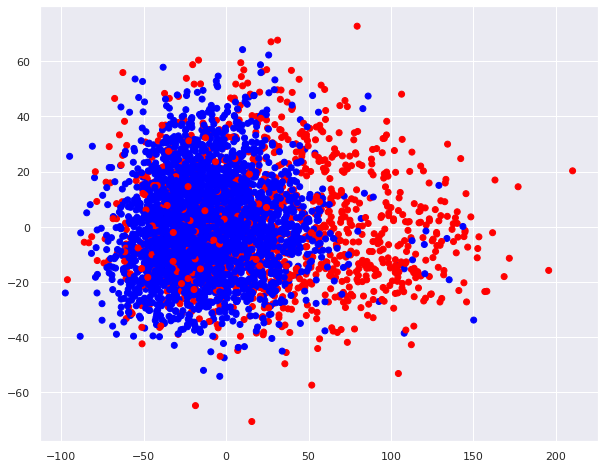

In [ ]:
# Отрисуем точки на плоскости при помощи функции scatter и зададим им цвет согласно их классу передав в аргумент c=['red' if i == 0 else 'blue' for i in df_plot["status"]]

plt.figure(figsize=(10,8))

plt.scatter(df_2d[:,0], df_2d[:,1], c = ['red' if i == 0 else 'blue' for i in df_plot["status"]])

plt.show()

Кажется, что явно прослаживаются зависимости в данных, но какие-то конкретные выводы сделать сложно.

### Отчет о работе модели (при помощи SHAP)

In [ ]:
# Установим библиотеку shap
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 12.1 MB/s eta 0:00:00


In [ ]:
# Импортируем библиотек shap
import shap

In [ ]:
# Создадим объект библиотеки shap -- explainer при помощи функции TreeExplainer библиотеки shap, который принимает модель
# например для лучше модели LGBM
explainer = shap.TreeExplainer(grid_LGBM.best_estimator_)

In [ ]:
# Посчитаем shap-values вызвав у explainer метод shap_values, передав в качестве аргумента датасет X_train

shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


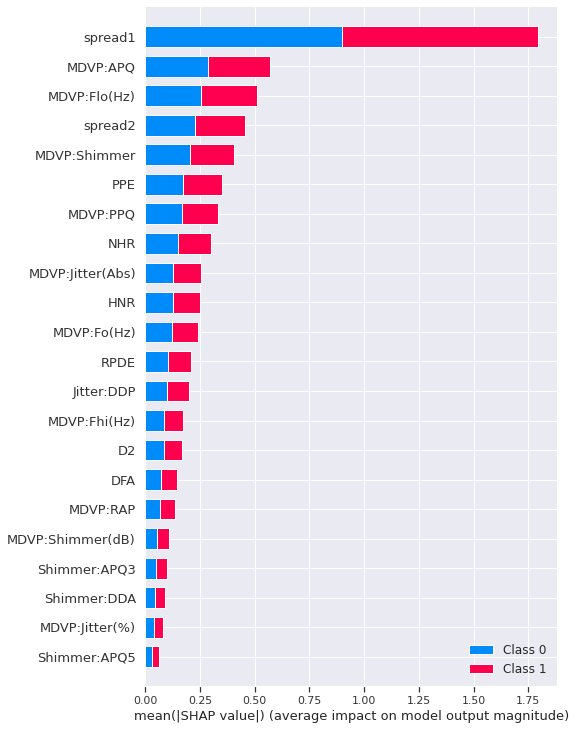

In [ ]:
# Посторим график важности фичей, вызвав summary_plot из библиотеки shap

shap.summary_plot(shap_values, X_train, max_display=25)

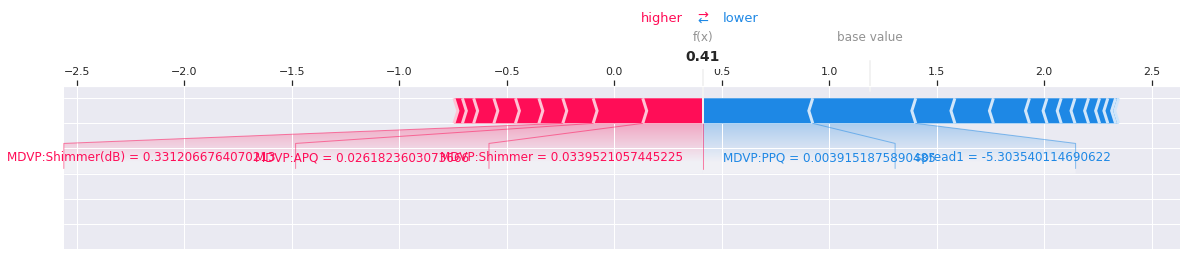

In [ ]:
# Можем посмотреть на влияние для одного
shap.force_plot(explainer.expected_value[1], shap_values[0][0], X_test.iloc[[0]], matplotlib = True)

In [ ]:
# Давайте посмотрим на тех, на ком наш алгоритм ошибся
# Например при помощи функции np.where, где будут сравнивать предсказания и метки

error_index = np.where(y_test != grid_LGBM.best_estimator_.predict(X_test))[0]
print(error_index)

[  9  17  22  24  29  32  41  45  48  59  65  69  73  78 122 131 137 144
 145 151 165 173 179 189 192 195 200 207 216 228 229 232 244 247 253 264
 268 276 291 306 308 311 326 339 346 349 353 363 368 372 376 378 395 402
 403 411 416 447 457 468 471 491 499 500 508 511 524 532 534 539 546 549
 554 557 568 577 578 579 580 581 585 586 607 609 616 617 620 621 622 633
 646 647 648 651 655 657 670 671 678 687 711 725 730 739 748 751 763 774
 789 790 797]


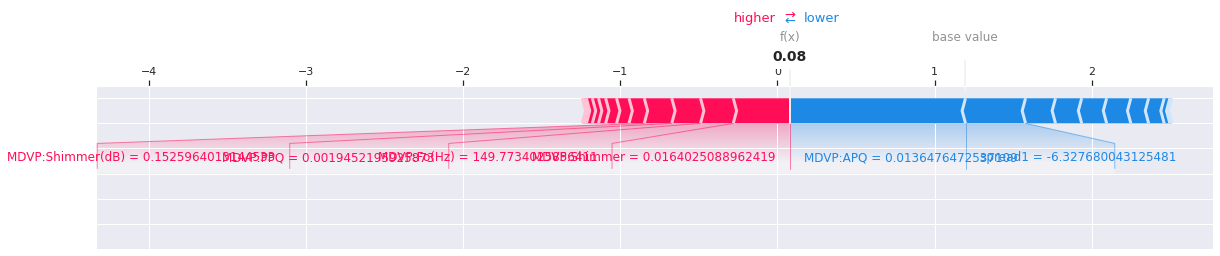

In [ ]:
# Можем посмотреть на влияние для одного
shap.force_plot(explainer.expected_value[1], shap_values[0][error_index[0]], X_test.iloc[[error_index[0]]], matplotlib = True)

Какие выводы можно сделать?

In [ ]:
# Ваши дополнительные эксперименты с SHAP тут:)
...